In [1]:
%run lgs03a_data_unification.ipynb

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
ref_wt_log

{'amacGFP': 3.9707333545555503,
 'avGFP': 3.719212132,
 'cgreGFP': 4.49691401841976,
 'ppluGFP': 4.225823746695675,
 'amacV14LGFP': 3.960964566532017}

In [4]:
def load_predictions_data():
    predictions = pd.read_csv(os.path.join(data_folder, 'predictions','experimentally_tested_predictions.csv'))
    fiji_ctrls = {'cgre_wt': 246, 'cgre_neg': 5, 'amac_wt': 65, 'amac_neg': 4, 'pplu_wt': 191, 'pplu_neg': 4}
    predictions['fiji_log_value'] = np.log10(predictions['fiji_value'])
    
    predictions['fiji_log_scaled'] = predictions[['fiji_log_value', 'gene']].apply(lambda x:
                                        (x[0] - np.log10(fiji_ctrls[x[1]+'_neg'])) / 
                            (np.log10(fiji_ctrls[x[1]+'_wt']) -  np.log10(fiji_ctrls[x[1]+'_neg'])), axis=1)
    
    predictions['fiji_log_scaled'] = predictions['fiji_log_scaled'].apply(lambda x: x if x>0 else 0)
    
    minval = {gene : data_aa[data_aa.gene==gene]['brightness'].min() 
              for gene in ['amacGFP', 'cgreGFP', 'ppluGFP', 'avGFP']}
    print(minval)
    predictions['fiji_library_values'] = predictions[['fiji_log_scaled', 'gene']].apply(lambda x:
                                    x[0] * (ref_wt_log[x[1]+'GFP'] - minval[x[1]+'GFP']) + minval[x[1]+'GFP']
                                                                                  , axis=1    )
    
    return predictions

In [5]:
predictions = load_predictions_data()

{'amacGFP': 2.652246341003323, 'cgreGFP': 2.7708520116421442, 'ppluGFP': 2.7708520116421442, 'avGFP': 1.283419239}


In [6]:
predictions['fraction_nonextant'] = predictions['non_extant_muts'] / predictions['distance']

# Comparison between genes

(-0.5, 8)

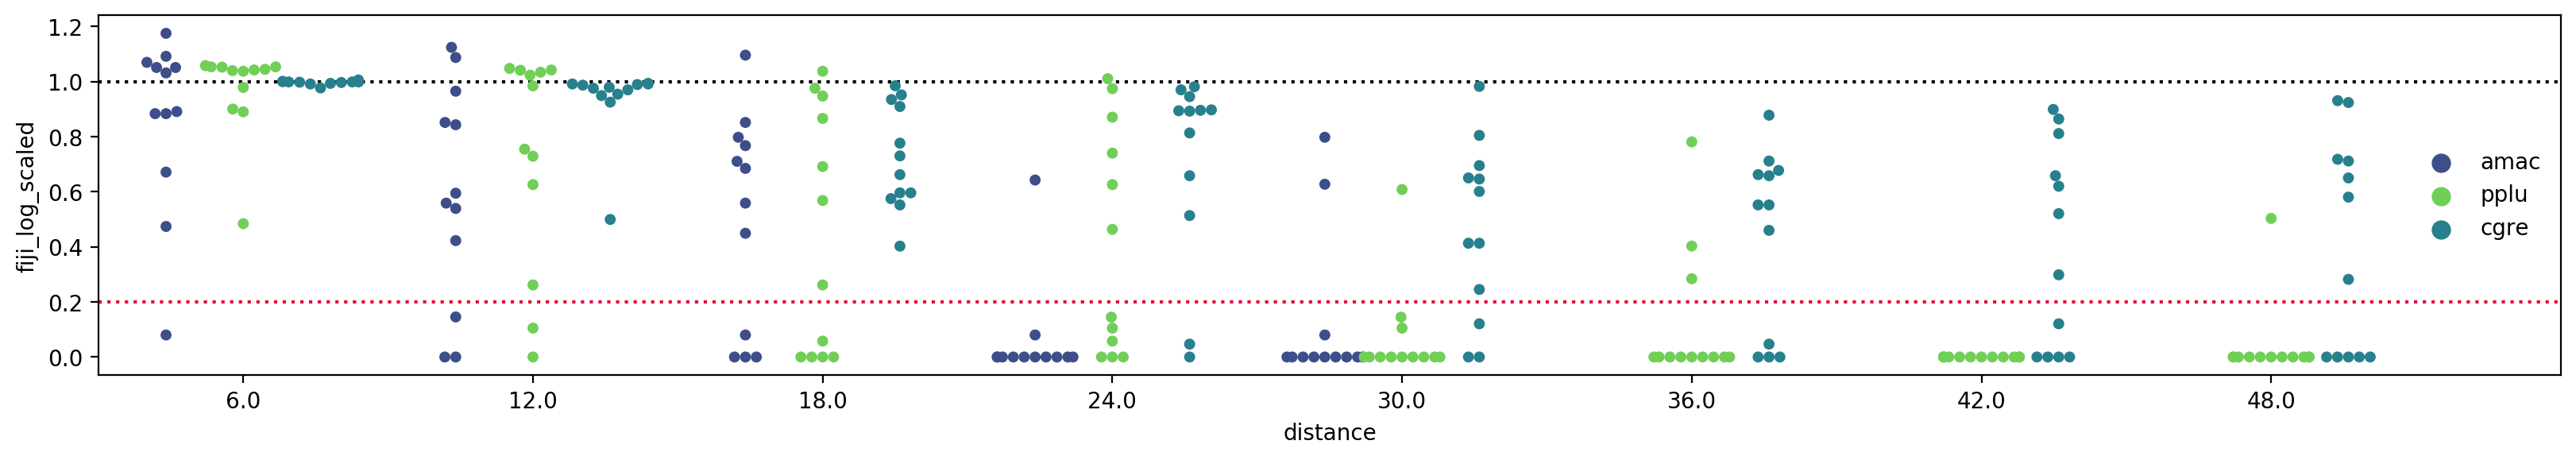

In [27]:
plt.figure(figsize=[20,3], dpi=200)
plt.axhline(1, linestyle=':', color='k')
plt.axhline(0.2, linestyle=':', color='crimson')
ax = sns.swarmplot(data=predictions, x='distance', y='fiji_log_scaled', hue='gene', size=5,
                   palette = [colors['amac'], colors['pplu'], colors['cgre']], dodge=True)
plt.legend(loc='center right', frameon=False)
plt.xlim(-0.5,8)

In [163]:
p_vals = pd.DataFrame(columns=['gene1', 'gene2', 'distance', 'p_fishers', 'p_mwu'])

i = 0
for distance in range(6,49,6):
    for pair in [('amac','pplu'), ('amac','cgre'), ('pplu','cgre')]:
        if 'amac' in pair and distance>30:
            pass
        elif pair[0] != pair[1]:
            all1 = predictions[(predictions.gene==pair[0]) & (predictions.distance==distance)]['fiji_log_scaled']
            all2 = predictions[(predictions.gene==pair[1]) & (predictions.distance==distance)]['fiji_log_scaled']
            
            alive1 = len([x for x in all1 if x>0.2])
            dead1 = 12 - alive1
            alive2 = len([x for x in all2 if x>0.2])
            dead2 = 12 - alive2
            
            p_vals.loc[i] = [pair[0], pair[1], distance, 
                         scipy.stats.fisher_exact([[alive1, alive2],[dead1, dead2]])[1],
                        scipy.stats.mannwhitneyu(all1,all2)[1]]
            i += 1

In [164]:
p_vals

,gene1,gene2,distance,p_fishers,p_mwu
0,amac,pplu,6,1.000000,0.272054
1,amac,cgre,6,1.000000,0.488468
2,pplu,cgre,6,1.000000,0.078336
3,amac,pplu,12,1.000000,0.201047
4,amac,cgre,12,0.217391,0.013082
5,pplu,cgre,12,0.478261,0.465486
6,amac,pplu,18,1.000000,0.465067
7,amac,cgre,18,0.093168,0.106998
8,pplu,cgre,18,0.037267,0.096432
9,amac,pplu,24,0.068650,0.002552


# Extant and non-extant mutations

In [100]:
def distance_fitness_extant_swarm(gene):
    plt.figure(figsize=[20,3], dpi=200)
    plt.axhline(1, linestyle=':', color='k') # wildtype level
    plt.axhline(0.2, linestyle=':', color='crimson') # non-fluorescence threshold
    ax = sns.swarmplot(data=predictions[predictions.gene == gene], 
                       x='distance', y='fiji_log_scaled', hue='fraction_nonextant', size=5, palette = 'mako', )
    ax.get_legend().remove()
    plt.xlim(-0.5,7.5)
    label_plot_axis(t=gene+'GFP', x='Number of mutations', y='Brightness')

    #colormap hack
    col = predictions[predictions.gene == gene]['fraction_nonextant']
    plt.scatter([x-10 for x in col], col, c=col, cmap='mako')
    plt.colorbar(pad=0.01).set_label('Fraction of mutations\nwhich are non-extant')

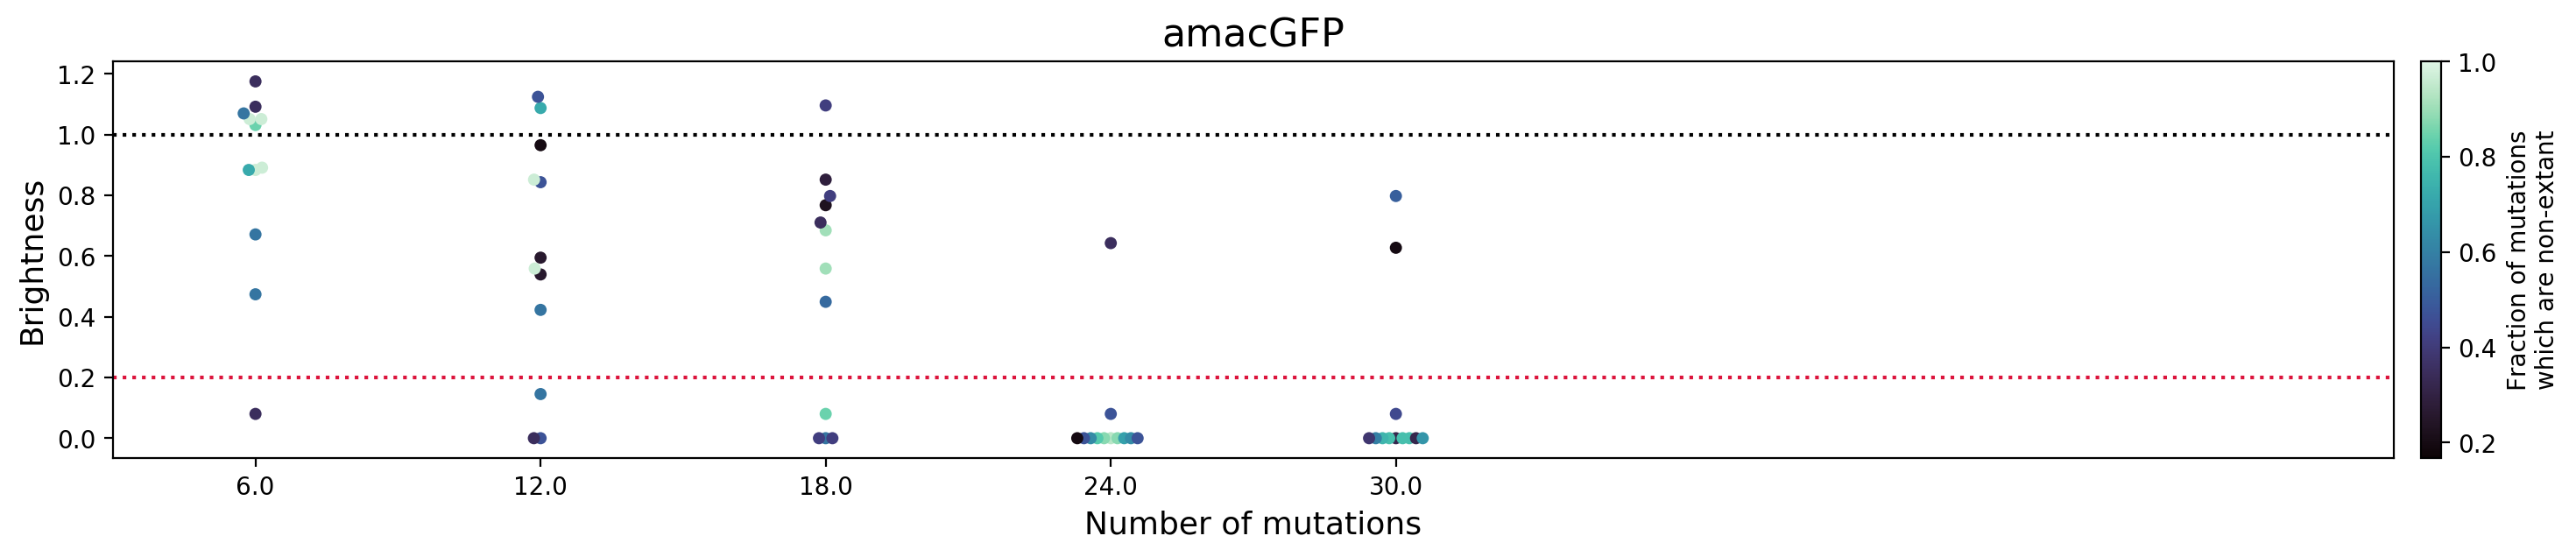

In [101]:
distance_fitness_extant_swarm('amac')

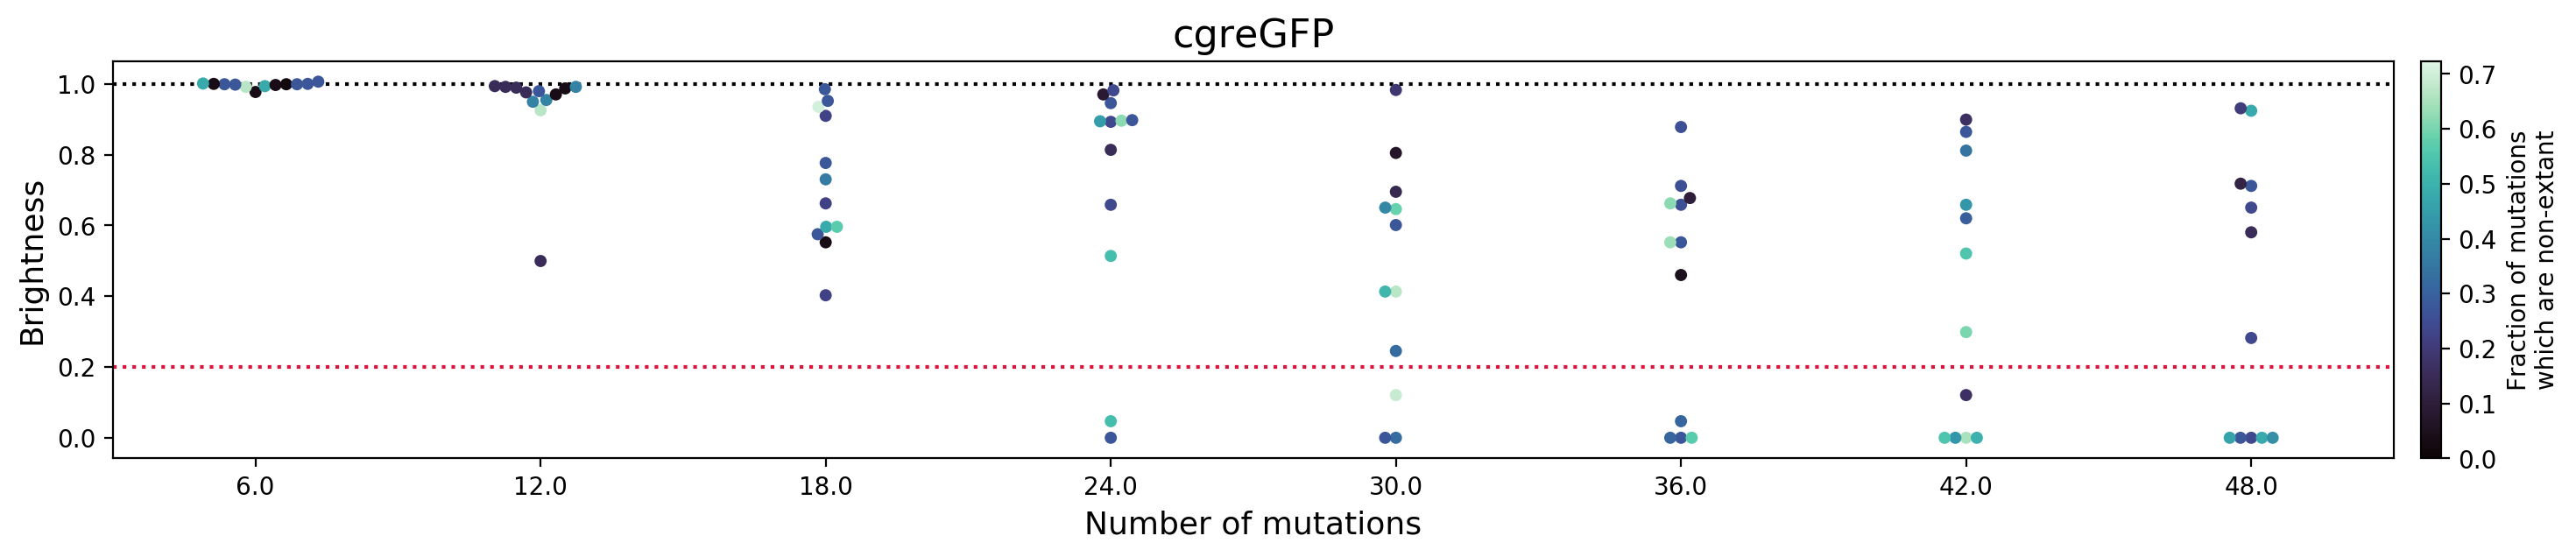

In [102]:
distance_fitness_extant_swarm('cgre')

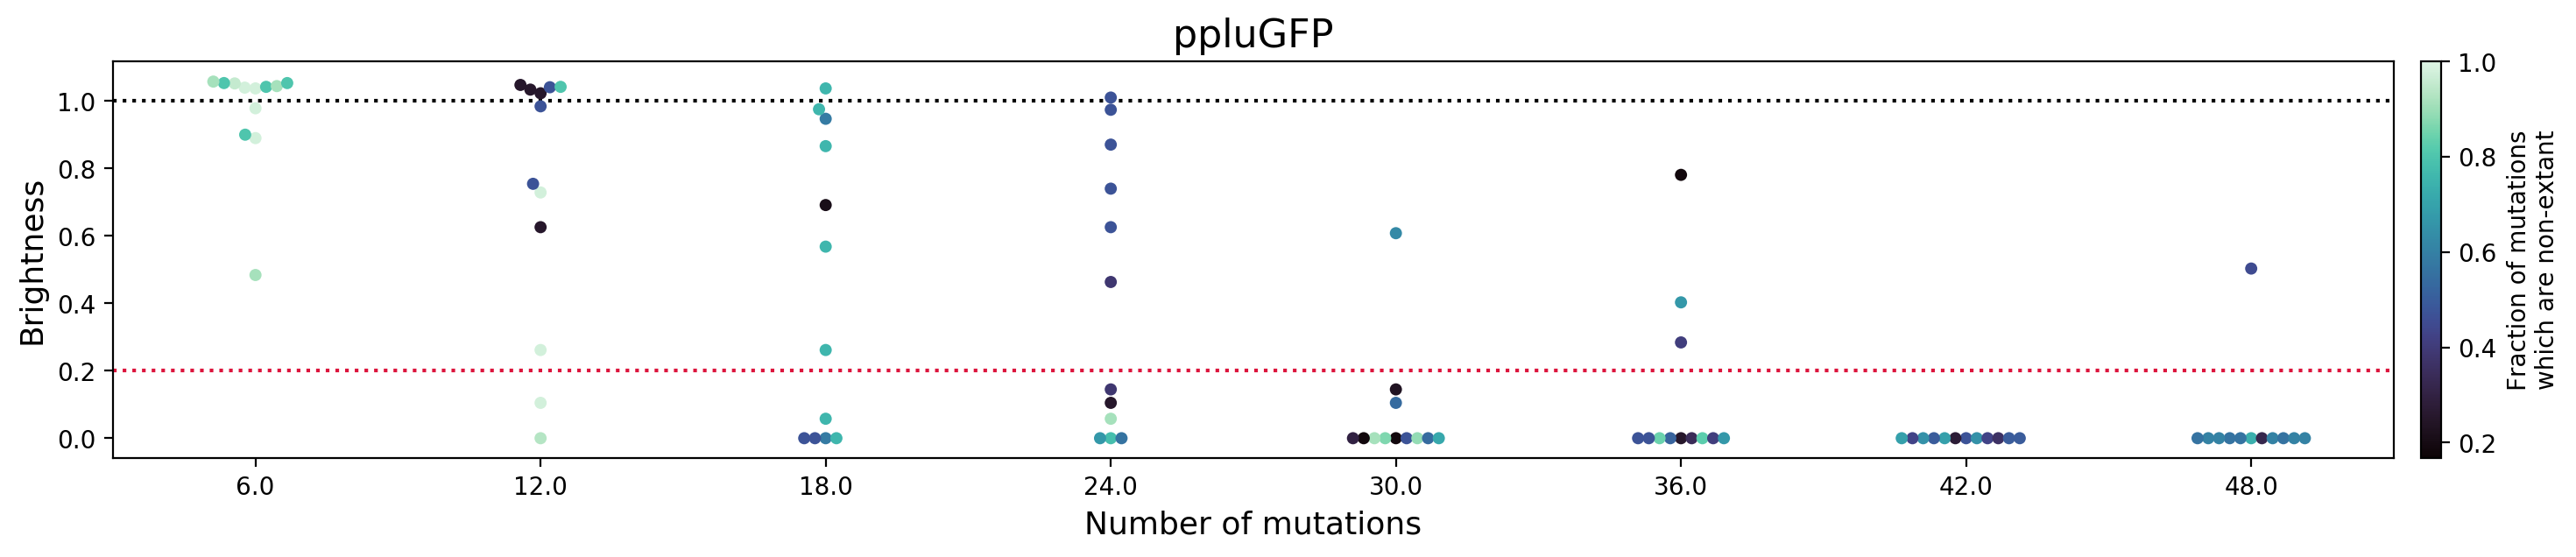

In [103]:
distance_fitness_extant_swarm('pplu')

# Conditionally deleterious mutations

In [7]:
import pickle
bg_data = pickle.load(open('mutation_effects_by_background_log10.pkl', 'rb'))

In [8]:
all_mutations = {gene : set(':'.join(predictions[predictions.gene==gene]['aa_genotype_pseudo']).split(':'))
                for gene in ['amac','cgre','pplu']}

In [110]:
gate_borders_log

{'amac': array([2.95303446, 3.19617619, 3.45720041, 3.64811596, 3.86814462,
        4.02255208, 4.18198642]),
 'cgre': array([3.07151381, 3.41396997, 3.74865309, 4.05623766, 4.27143499,
        4.4214147 , 4.56988282]),
 'pplu': array([3.07151381, 3.37812525, 3.67407999, 3.9626534 , 4.12316537,
        4.26158401, 4.39274091])}

amac
all 0.15041782729805014
selected 0.1111111111111111
cgre
all 0.25925925925925924
selected 0.23157894736842105
pplu
all 0.18693693693693694
selected 0.09615384615384616


([<matplotlib.axis.XTick at 0x2780a90f648>,
 <a list of 3 Text xticklabel objects>)

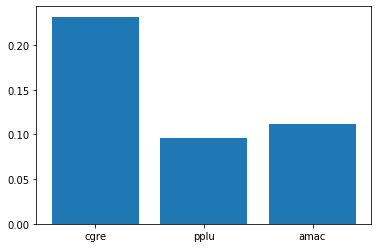

In [127]:
values = { 'cgre':0, 'pplu':0,'amac':0, }
for gene in ['amac','cgre','pplu']:
    fitness_min = ref_wt_log[f'{gene}GFP'] - 0.03
#     fitness_min = gate_borders_log[gene][2]
    fitness_max = 10#gate_borders_log[gene][-2]
    selected = set(':'.join(predictions[(predictions.gene == gene) & 
                                        (predictions.fiji_library_values > fitness_min) 
                                        & (predictions.fiji_library_values < fitness_max)
                                       ]['aa_genotype_pseudo']).split(':'))


    e = -0.3
    flippers_all = []
    flippers_successful = []
    for mut in all_mutations[gene]:
        if mut in bg_data[gene+'GFP'] and min(bg_data[gene+'GFP'][mut]['mut_effect']) < e:
            flippers_all.append(mut)
    for mut in selected:
        if mut in bg_data[gene+'GFP'] and min(bg_data[gene+'GFP'][mut]['mut_effect']) < e:
            flippers_successful.append(mut)
    print(gene)
    print('all', len(flippers_all) / len(all_mutations[gene]))
    print('selected', len(flippers_successful) / len(selected))
    values[gene] = len(flippers_successful) / len(selected)
    
plt.bar(range(3), values.values(), )
plt.xticks(range(3),values.keys())

In [102]:
fitness = 0.90
selected = {gene : set(':'.join(predictions[(predictions.gene == gene) & 
                                    (predictions.fiji_log_scaled > fitness)]['aa_genotype_pseudo']).split(':'))
                for gene in ['amac','cgre','pplu']}

e = -0.3
for gene in ['amac', 'cgre', 'pplu']:
    flippers_all = []
    flippers_successful = []
    for mut in all_mutations[gene]:
        if mut in bg_data[gene+'GFP'] and min(bg_data[gene+'GFP'][mut]['mut_effect']) < e:
            flippers_all.append(mut)
    for mut in selected[gene]:
        if mut in bg_data[gene+'GFP'] and min(bg_data[gene+'GFP'][mut]['mut_effect']) < e:
            flippers_successful.append(mut)
    print(gene)
    print('all', len(flippers_all) / len(all_mutations[gene]))
    print('selected', len(flippers_successful) / len(selected[gene]))

amac
all 0.15041782729805014
selected 0.1267605633802817
cgre
all 0.25925925925925924
selected 0.2536231884057971
pplu
all 0.18693693693693694
selected 0.09016393442622951


### testing....

In [14]:
data_aa

,aa_genotype_pseudo,aa_genotype_native,gene,n_mut,quasipos_genotype,ddG_prediction,brightness,measured_effect,expected_effect,epistasis,n_mut_extant,has_buried_mutation
0,I13F:Q210L,I10F:Q203L,amacGFP,2,82F:334L,NaN,3.881205,-0.089529,-0.088793,-0.000736,0.0,False
1,K54E,K51E,amacGFP,1,134E,0.866,3.955077,-0.015656,-0.015656,0.000000,1.0,False
2,K81M:I203T,K78M:I196T,amacGFP,2,161M:325T,NaN,3.922354,-0.048379,-0.040794,-0.007585,1.0,False
3,V14L,V11L,amacGFP,1,88L,1.976,3.960965,-0.009769,-0.009769,0.000000,1.0,True
4,I13T:F148L,I10T:F144L,amacGFP,2,82T:245L,NaN,2.735211,-1.235522,-1.208990,-0.026532,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
147945,Y95N:N108S:I174F,Y91N:N104S:I170F,avGFP,3,181N:194S:277F,NaN,1.552090,-2.167122,-2.302820,0.135699,1.0,True
147946,Y95N:Q180L:L213Q:T237A:M240V,Y91N:Q176L:L206Q:T229A:M232V,avGFP,5,181N:286L:337Q:382A:389V,NaN,1.301030,-2.418182,-2.435793,0.017611,1.0,True
147947,Y95R:I155N:N204S,Y91R:I151N:N197S,avGFP,3,181R:254N:327S,NaN,1.301030,-2.418182,NaN,NaN,2.0,True
147948,Y95R:I170T:L243P,Y91R:I166T:L235P,avGFP,3,181R:271T:392P,NaN,1.301517,-2.417695,NaN,NaN,1.0,True


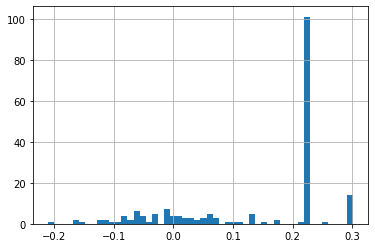

In [82]:
predictions['additive_expectation'].hist(bins=50)

In [80]:
def distance_fitness_additive_swarm(gene):
    plt.figure(figsize=[20,3], dpi=200)
    plt.axhline(1, linestyle=':', color='k') # wildtype level
    plt.axhline(0.2, linestyle=':', color='crimson') # non-fluorescence threshold
    ax = sns.swarmplot(data=predictions[predictions.gene == gene], 
                       x='distance', y='fiji_log_scaled', hue='additive_expectation', size=5, palette = 'bwr', 
                      )
    ax.get_legend().remove()
    plt.xlim(-0.5,7.5)
    label_plot_axis(t=gene+'GFP', x='Number of mutations', y='Brightness')

    #colormap hack
    col = predictions[predictions.gene == gene]['additive_expectation']
    plt.scatter([x-10 for x in col], col, c=col, cmap='bwr')
    plt.colorbar(pad=0.01).set_label('Fraction of mutations\nwhich are non-extant')

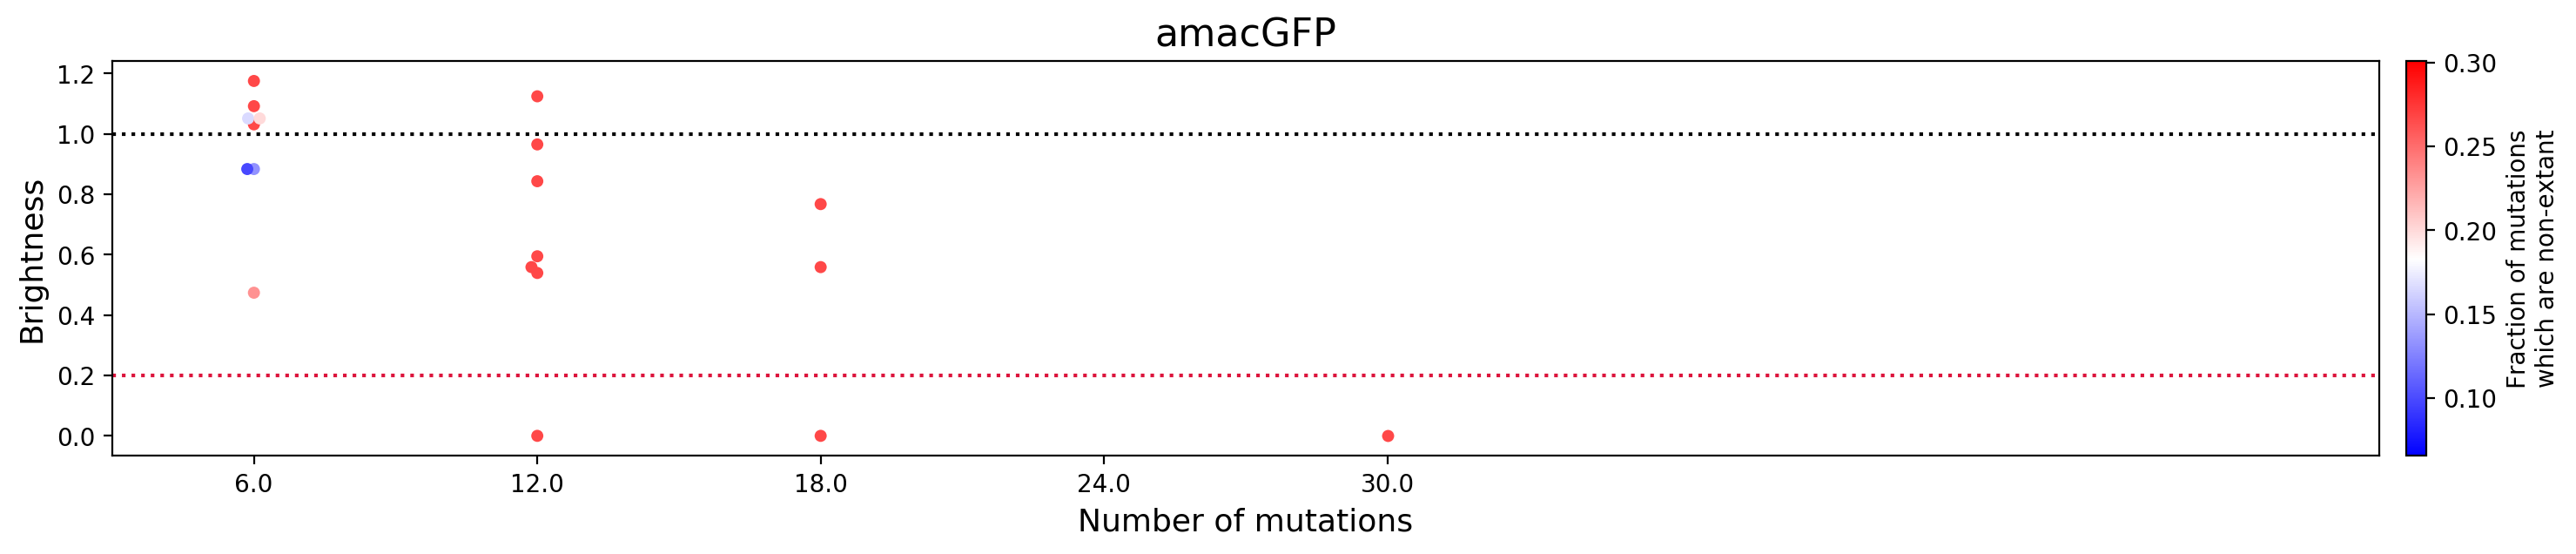

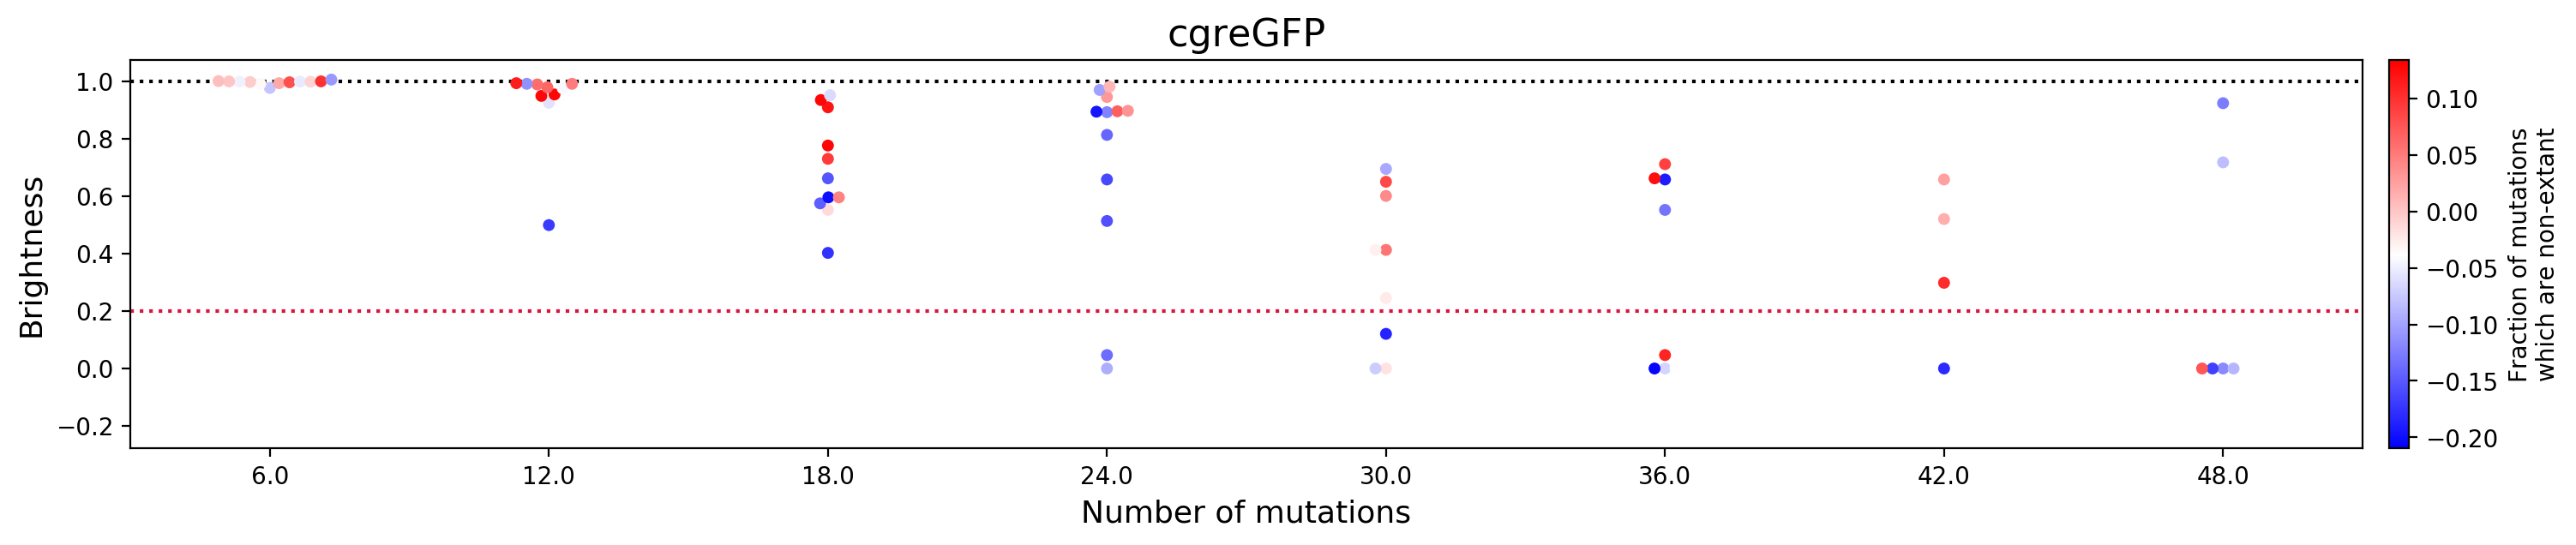

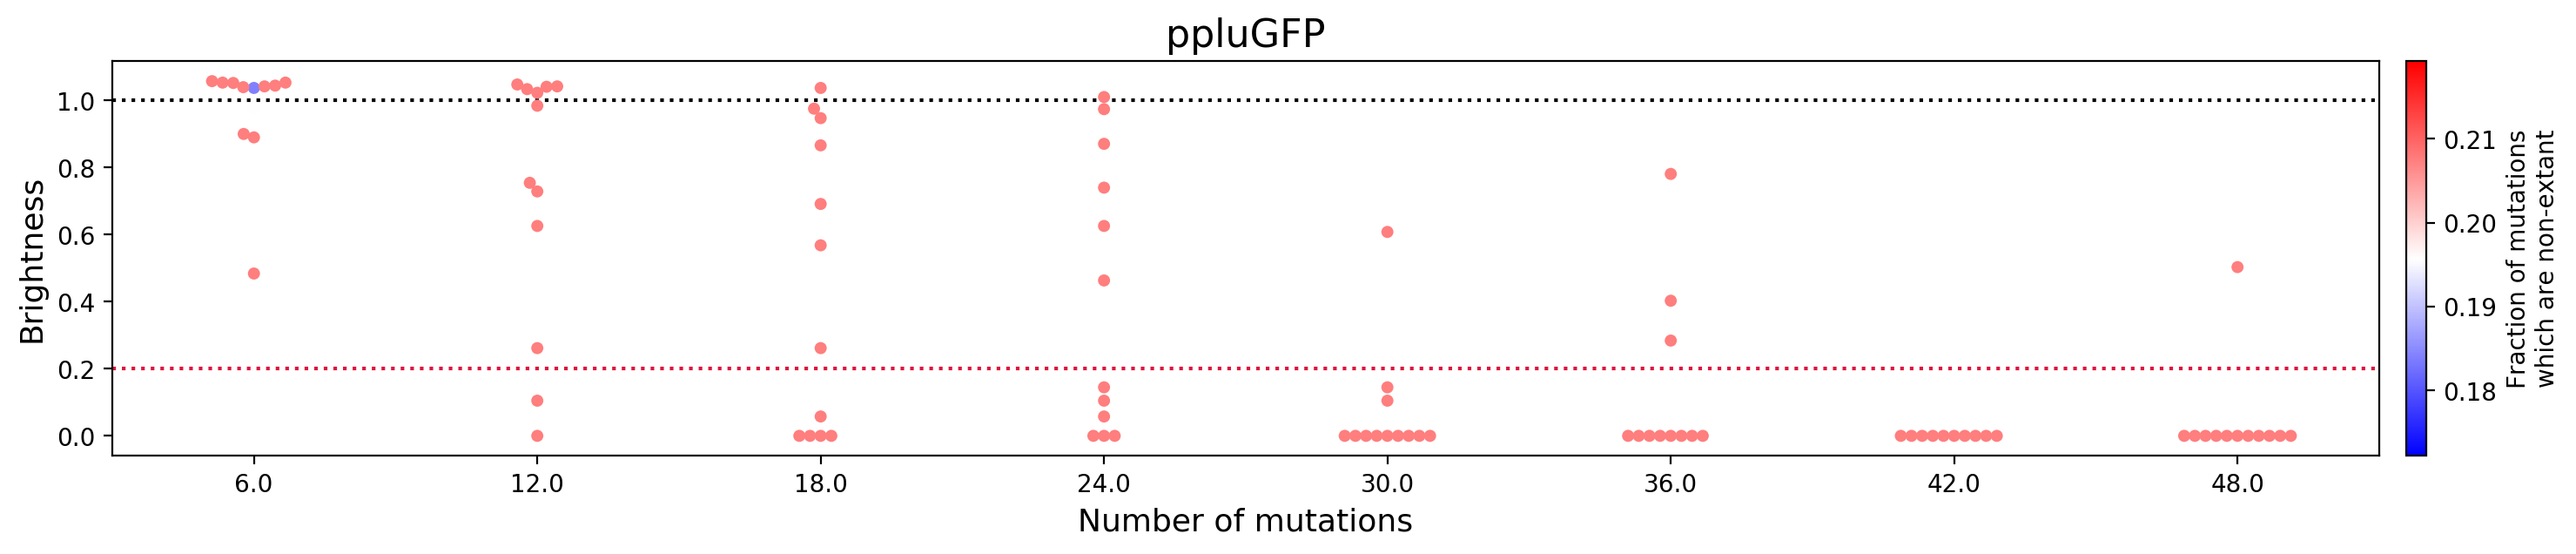

In [81]:
distance_fitness_additive_swarm('amac')
distance_fitness_additive_swarm('cgre')
distance_fitness_additive_swarm('pplu')

### Epistasis

In [44]:
import pickle

In [14]:
bg_effects_log = pickle.load(open('mutation_effects_by_background_log10.pkl', 'rb'))

In [15]:
def get_expected_effect_bg(muts_str, siffects_dict, min_brightness, max_brightness):
    muts = muts_str.split(':')
    expectation = 0 
    try:
        for m in muts:
            expectation += siffects_dict[m]['mut_effect'].median()
        if expectation > max_brightness:
            return max_brightness
        elif expectation < min_brightness:
            return min_brightness
        else:
            return expectation
    except:
        return np.nan

In [12]:
predictions['additive_expectation'] = predictions[['gene', 'aa_genotype_pseudo']].apply(lambda x:
                                            get_expected_effect(x[1], eval(f'siffects_{x[0]}_log'),
                                min_brightness = data_aa[data_aa.gene==x[0]+'GFP']['brightness'].min() - ref_wt_log[x[0]+'GFP'],
                                max_brightness = data_aa[data_aa.gene==x[0]+'GFP']['brightness'].max() - ref_wt_log[x[0]+'GFP'])
                                                                                        + ref_wt_log[x[0]+'GFP'],
                                                                                       axis=1)

In [16]:
predictions['additive_expectation_bg'] = predictions[['gene', 'aa_genotype_pseudo']].apply(lambda x:
                                            get_expected_effect_bg(x[1], bg_effects_log[x[0]+'GFP'],
                                min_brightness = data_aa[data_aa.gene==x[0]+'GFP']['brightness'].min() - ref_wt_log[x[0]+'GFP'],
                                max_brightness = data_aa[data_aa.gene==x[0]+'GFP']['brightness'].max() - ref_wt_log[x[0]+'GFP'])
                                                                                        + ref_wt_log[x[0]+'GFP'],
                                                                                       axis=1)

In [17]:
predictions['epistasis'] = predictions['fiji_library_values'] - predictions['additive_expectation']

In [18]:
predictions['epistasis_bg'] = predictions['fiji_library_values'] - predictions['additive_expectation_bg']

''

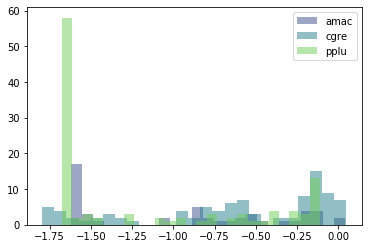

In [61]:
plt.hist(predictions[predictions.gene=='amac']['epistasis_bg'],
        bins = 25, alpha=0.5, color=colors['amac'], label='amac')

plt.hist(predictions[predictions.gene=='cgre']['epistasis_bg'],
        bins = 25, alpha=0.5, color=colors['cgre'], label='cgre')

plt.hist(predictions[predictions.gene=='pplu']['epistasis_bg'],
        bins = 25, alpha=0.5, color=colors['pplu'], label='pplu')

plt.legend()
;

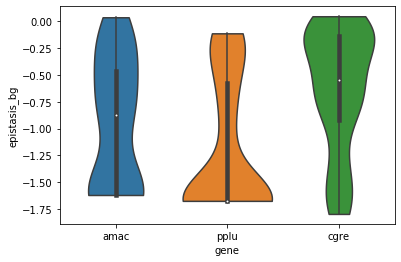

In [66]:
sns.violinplot(data = predictions, x = 'gene', y='epistasis_bg', cut=0)

In [97]:
gene = 'pplu'

ntot = len(predictions[(predictions.gene==gene) & (predictions.epistasis_bg.notnull())])
ne_03 = len(predictions[(predictions.gene==gene) & (predictions.epistasis_bg < -0.3)
#                        & (predictions.epistasis_bg > -1)
                       ])
ne_1 = len(predictions[(predictions.gene==gene) & (predictions.epistasis_bg < -1)])

print(gene)
print('-1<e<-0.3,  ', ne_03/ntot, )
print('e<-1,  ', ne_1/ntot)

pplu
-1<e<-0.3,   0.8148148148148148
e<-1,   0.6481481481481481


In [60]:
def get_worst_effect(mut, gene, d = bg_effects_log):
    if mut in d[gene]:
        return d[gene][mut]['mut_effect'].min()
    else:
        return np.nan
    
def get_worst_effect_multi(genotype, gene, d = bg_effects_log):
    genotype = genotype.split(':')
    worsts = []
    for mut in genotype:
        worsts.append(get_worst_effect(mut, gene, d))
        
    return np.nanmin(worsts)

def get_worst_effect_multi_average(genotype, gene, d = bg_effects_log):
    genotype = genotype.split(':')
    worsts = []
    for mut in genotype:
        worsts.append(get_worst_effect(mut, gene, d))
        
    return np.nanmean(worsts)

In [43]:
predictions['worst_mut_effect'] = predictions[['aa_genotype_pseudo','gene']].apply(lambda x:
                                                    get_worst_effect_multi(genotype = x[0], gene=x[1]+'GFP'),
                                                                                  axis=1)

In [61]:
predictions['worst_mut_effect_average'] = predictions[['aa_genotype_pseudo','gene']].apply(lambda x:
                                                get_worst_effect_multi_average(genotype = x[0], gene=x[1]+'GFP'),
                                                                                  axis=1)

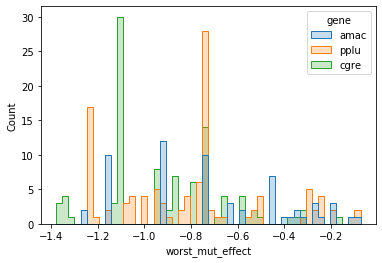

In [47]:
sns.histplot(data = predictions, x='worst_mut_effect', hue='gene', element='step',
            bins=50)

In [247]:
def plot_percent_cond_del_muts(genes):
    values = { gene : 0 for gene in genes }
    stds = {'amac':0.031, 'cgre':0.028, 'pplu':0.027}
    sel = {}
    for gene in genes:
#         fitness_min = ref_wt_log[f'{gene}GFP'] - stds[gene]*2
        fitness_min = gate_borders_log[gene][1]
        fitness_max = 10#gate_borders_log[gene][-2]
        selected = set(':'.join(predictions[(predictions.gene == gene) & 
                                            (predictions.fiji_library_values > fitness_min) 
                                            & (predictions.fiji_library_values < fitness_max)
                                           ]['aa_genotype_pseudo']).split(':'))


        e = -0.3
        flippers_all = []
        flippers_successful = []
        for mut in all_mutations[gene]:
            if mut in bg_data[gene+'GFP'] and min(bg_data[gene+'GFP'][mut]['mut_effect']) < e:
                flippers_all.append(mut)
        for mut in selected:
            if mut in bg_data[gene+'GFP'] and min(bg_data[gene+'GFP'][mut]['mut_effect']) < e:
                flippers_successful.append(mut)
        print(gene)
        print('all', len(flippers_all) / len(all_mutations[gene]))
        print('selected', len(flippers_successful) / len(selected))
        print(len(selected))
        sel[gene] = len(selected)
        values[gene] = 100 * len(flippers_successful) / len(selected)
        
    plt.bar(range(3), values.values(), color=[colors[gene] for gene in genes], edgecolor='k', )
    plt.xticks(range(3),[f'{names[gene]}\nn = {sel[gene]}' for gene in values.keys()], )
    plt.ylabel('Percent of total mutations')
    plt.title('Conditionally deleterious mutations\nin functional ML-generated genotypes')


amac
all 0.15041782729805014
selected 0.13333333333333333
210
cgre
all 0.25925925925925924
selected 0.26976744186046514
215
pplu
all 0.18693693693693694
selected 0.13692946058091288
241


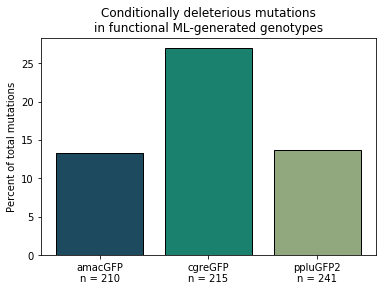

In [248]:
plot_percent_cond_del_muts(['amac','cgre','pplu'])

In [264]:
predictions['expectation_if_worst'] = predictions[['gene','worst_mut_effect']].apply(lambda x:
                                                ref_wt_log[x[0]+'GFP'] + x[1], axis=1)

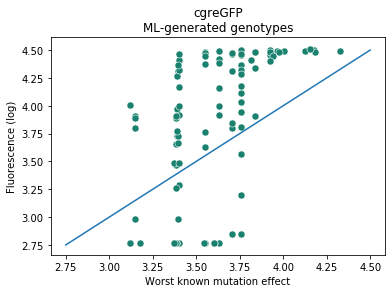

In [268]:
def scatter_worstmut_vs_fitness(gene):

    sns.scatterplot(data = predictions[predictions.gene==gene], y = 'fiji_library_values', 
                    x = 'expectation_if_worst',#'worst_mut_effect', 
                    marker='o', #hue='distance'
                    color=colors[gene], edgecolor='w' , s=50
                   )
    plt.ylabel('Fluorescence (log)')
    plt.xlabel('Worst known mutation effect')
    plt.title(f'{names[gene]}\nML-generated genotypes')
        
    plt.plot([2.75,4.5],[2.75,4.5])
#     plt.axhline(gate_borders_log[gene][0], color='crimson', linestyle='--', linewidth=1)
#     lethality = gate_borders_log[gene][0] - ref_wt_log[f'{gene}GFP']
#     plt.axvline(lethality, color='crimson', linestyle='--', linewidth=1)

scatter_worstmut_vs_fitness('cgre')

In [257]:
ref_wt_log

{'amacGFP': 3.9707333545555503,
 'avGFP': 3.719212132,
 'cgreGFP': 4.49691401841976,
 'ppluGFP': 4.225823746695675,
 'amacV14LGFP': 3.960964566532017}

In [259]:
gate_borders_log

{'amac': array([2.95303446, 3.19617619, 3.45720041, 3.64811596, 3.86814462,
        4.02255208, 4.18198642]),
 'cgre': array([3.07151381, 3.41396997, 3.74865309, 4.05623766, 4.27143499,
        4.4214147 , 4.56988282]),
 'pplu': array([3.07151381, 3.37812525, 3.67407999, 3.9626534 , 4.12316537,
        4.26158401, 4.39274091])}

amac
all 0.15041782729805014
selected 0.13333333333333333
210
cgre
all 0.25925925925925924
selected 0.26976744186046514
215
pplu
all 0.18693693693693694
selected 0.13692946058091288
241


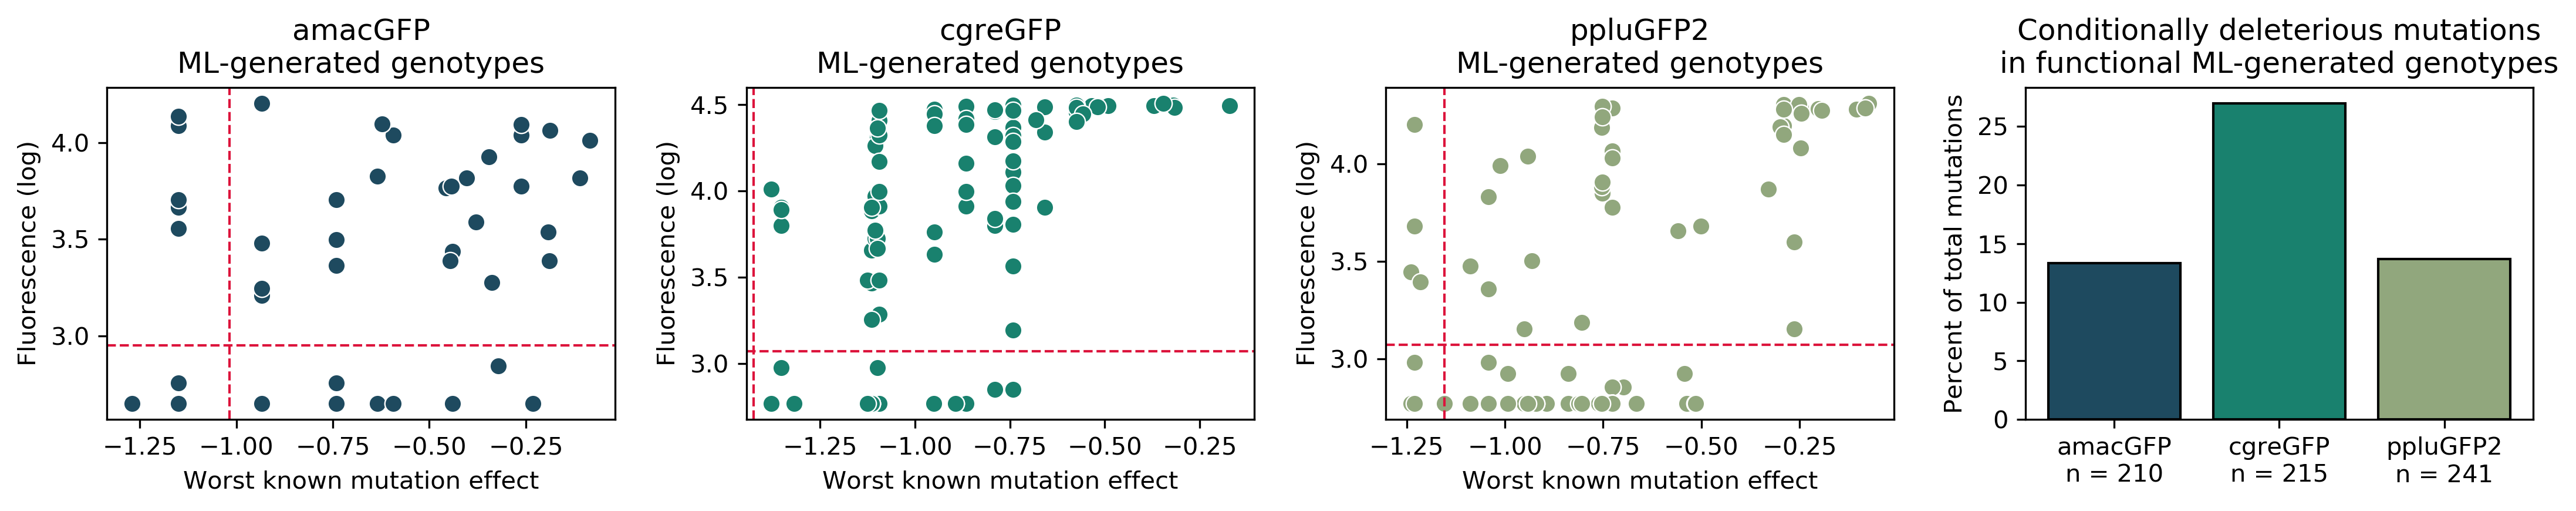

In [258]:
plt.figure(figsize=[15,3], dpi=300)

for i,g in zip([1,2,3], ['amac','cgre','pplu']):
    plt.subplot(1,4,i)
    scatter_worstmut_vs_fitness(g)
    
plt.subplot(1,4,4)
plot_percent_cond_del_muts(['amac','cgre','pplu'])
plt.tight_layout()

# plt.savefig(os.path.join(figures_folder, 'eLife_final_figs', 'elife_suppl_fig14.png'), dpi=300)

Text(0, 0.5, 'measured brightness')

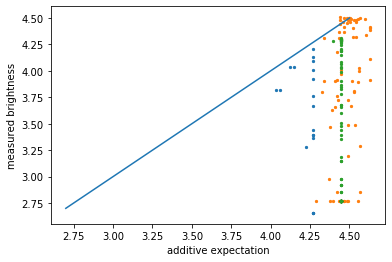

In [30]:
plt.scatter(predictions[predictions.gene=='amac']['additive_expectation'],
           predictions[predictions.gene=='amac']['fiji_library_values'], s=5, label='amac')
plt.scatter(predictions[predictions.gene=='cgre']['additive_expectation'],
           predictions[predictions.gene=='cgre']['fiji_library_values'], s=5, label='cgre')
plt.scatter(predictions[predictions.gene=='pplu']['additive_expectation'],
           predictions[predictions.gene=='pplu']['fiji_library_values'], s=5, label='pplu')
plt.plot([2.7,4.5],[2.7,4.5])
plt.xlabel('additive expectation')
plt.ylabel('measured brightness')

In [86]:
0.2/0.03

6.666666666666667